## Main
### DAQ(s) manual output
### Kuali CO2 laser control

In [3]:
%matplotlib widget

import os
import csv
import time
import scipy
import psutil
import pyvisa
import random
import asyncio
import threading
import numpy as np
import pandas as pd
import nidaqmx as ni
from ctypes import *
from nidaqmx import constants
import ipywidgets as widgets
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.autolayout'] = True; plt.rc('font', size=16)
plt.rc('text', usetex=False); plt.rc('font', family='serif'); plt.rcParams['figure.figsize'] = (8, 4)

## init params
resMan = pyvisa.ResourceManager()
outputMain = widgets.Output()

if len(resMan.list_resources()) > 1: instAddress = list(resMan.list_resources())[0] ## ignore if nothing found, can "simulate" from personal laptop
instHandler = 'None'
connStatus = 'Idle'

## classes
class Stacks(list):
    def __init__(self, maxSize):
        super().__init__()
        self.maxSize = maxSize

    def init(self, element):
        for i in range(self.maxSize):
            self.append(element)

    def push(self, element):
        self.append(element)
    
    def append(self, element):
        super().append(element)
        if super().__len__() > self.maxSize:
            super().__delitem__(0)

## init widgets
scanButton = widgets.Button(description='Scan for Instruments'); checkConnectButton = widgets.Button(description='Check Connection')
connectInstMeasButton = widgets.Button(description='Connect'); stopMeasButton = widgets.Button(description='Stop & Disconnect')
instIDBox = widgets.Text(); dropdownBox = widgets.Dropdown(options=list(resMan.list_resources()), description='Address')

## scan and connect
scanConnectButtonHandler = widgets.HBox([scanButton, checkConnectButton])
instFindHandler = widgets.VBox([scanConnectButtonHandler, dropdownBox])
instStartHandler = widgets.VBox([instIDBox, widgets.HBox([connectInstMeasButton, stopMeasButton])])

## first accordion 
DAQ1BoxConn = widgets.Text(description='DAQ1 Status', value='Not Connected', style={'description_width':'initial'}); DAQ2BoxConn = widgets.Text(description='DAQ 2 Status', value='Not Connected', style={'description_width':'initial'})
DAQ1AddrBox = widgets.IntText(description='DAQ1 Address [devX]', value=2, style={'description_width':'initial'}); DAQ2AddrBox = widgets.IntText(description='DAQ 2 Address [devX]', value=3, style={'description_width':'initial'})
DAQ1ConnButton = widgets.Button(description='Connect DAQ1', style={'description_width':'initial'}); DAQ2ConnButton = widgets.Button(description='Connect DAQ 2', style={'description_width':'initial'})
DAQ1AO0Slider = widgets.FloatSlider(description='DAQ1 AO0 [V]', value=0, min=-10, max=10, step=0.01, continuous_update=True, readout=True, disabled=True, style={'description_width':'initial'}); DAQ1AO1Slider = widgets.FloatSlider(description='DAQ1 AO1 [V]', value=0, min=-10, max=10, step=0.01, continuous_update=True, readout=True, disabled=True, style={'description_width':'initial'}); 
DAQ2AO0Slider = widgets.FloatSlider(description='DAQ2 AO0 [V]', value=0, min=-10, max=10, step=0.01, continuous_update=True, readout=True, disabled=True, style={'description_width':'initial'}); DAQ2AO1Slider = widgets.FloatSlider(description='DAQ2 AO1 [V]', value=0, min=-10, max=10, step=0.01, continuous_update=True, readout=True, disabled=True, style={'description_width':'initial'}); 
multiDAQLogBox = widgets.Textarea(layout=widgets.Layout(height='100px', width='100%'))

multiDAQHandler = widgets.VBox([widgets.HBox([DAQ1BoxConn, DAQ2BoxConn, DAQ1ConnButton]),
                                widgets.HBox([DAQ1AddrBox, DAQ2AddrBox, DAQ2ConnButton]),
                                widgets.HBox([DAQ1AO0Slider, DAQ2AO0Slider]),
                                widgets.HBox([DAQ1AO1Slider, DAQ2AO1Slider]),
                            multiDAQLogBox
                            ])

## second accordion 
laserControlConnBox = widgets.Text(description='Laser Control Status', value='Not Connected', style={'description_width':'initial'}); laserControlConnButton = widgets.Button(description='Connect', style={'description_width':'initial'})
laserDAQAddrBox = widgets.IntText(description='Laser DAQ Address [devX]', value=1, style={'description_width':'initial'})
laserFaultTEMPSignal = widgets.Button(description='TEMP', disabled=True, button_style='success'); laserFaultCMDSignal = widgets.Button(description='CMD', disabled=True, button_style='success')
laserFaultSWRSignal = widgets.Button(description='SWR', disabled=True, button_style='success'); laserFaultINTSignal = widgets.Button(description='INT', disabled=True, button_style='success')

laserPRF = widgets.BoundedFloatText(description='Pulse Repetition Frequency [kHz]', value=24.5, min=0, max=25, step=0.001, style={'description_width':'initial'})
laserDC = widgets.BoundedFloatText(description='Duty Cycle [%]', value=50, min=0, max=100, step=0.001, style={'description_width':'initial'})
laserDuration = widgets.BoundedFloatText(description='Duration [ms]', value=50, min=0, max=100, step=0.001, style={'description_width':'initial'})
laserPlotRFButton = widgets.Button(description='Plot RF', style={'description_width':'initial'})
laserFireButton = widgets.Button(description='Fire!', style={'description_width':'initial'})
laserLogBox = widgets.Textarea(layout=widgets.Layout(height='100px', width='100%')); laserPlotBox = widgets.Output()

laserControlHandler = widgets.VBox([widgets.HBox([laserFaultTEMPSignal, laserFaultCMDSignal, laserFaultSWRSignal, laserFaultINTSignal, laserDAQAddrBox, laserControlConnBox, laserControlConnButton]),
                                    widgets.HBox([laserPRF, laserDC, laserDuration, laserPlotRFButton, laserFireButton]),
                            laserLogBox, laserPlotBox
                            ])

## all accordion
AccordHandler = widgets.Accordion(children=[multiDAQHandler, laserControlHandler])
AccordHandler.set_title(0, 'MultiDAQ')
AccordHandler.set_title(1, 'Kuali CO2 Laser')

## display widgets
display(
    widgets.VBox([widgets.Label('AdvancedInterconnect: Optimized for Kuali'),
        widgets.HBox([instFindHandler, instStartHandler]),
        AccordHandler]), 
    outputMain)

## functions & classes
def logInBox(textbox, message):
    textbox.value = str(datetime.now()) + '   ' + message + '\n' + textbox.value

## handlers
def scanButtonHandler(value):
    with outputMain:
        dropdownBox.options = list(resMan.list_resources())
        print(str(datetime.now()) + '   Scanning for instruments...')
scanButton.on_click(scanButtonHandler)

def dropdownBoxHandler(value):
    global instAddress
    if value['type'] == 'change' and value['name'] == 'value':
        with outputMain:
            instAddress = value['new']
            print(str(datetime.now()) + '   Selected device address: ' + instAddress)
dropdownBox.observe(dropdownBoxHandler)

def checkConnectButtonHandler(value):
    global instHandler, instAddress
    with outputMain:
        connectInstMeasButton.disabled = True
        print(str(datetime.now()) + '   Connecting to: ' + instAddress)
        instHandler = resMan.open_resource(instAddress)
        instIDBox.value = instHandler.query('*IDN?').strip()
        print(str(datetime.now()) + '   Connected to: ' + instIDBox.value)
        connectInstMeasButton.disabled = False
checkConnectButton.on_click(checkConnectButtonHandler)

def connectInstButtonHandler(value):
    global instHandler
    with outputMain:
        if instIDBox.value != '':
                instHandler = resMan.open_resource(instAddress)
                print(str(datetime.now()) + '   Connection established to: ' + instIDBox.value); instIDBox.value = ''
        else:
            instIDBox.value = 'Check connection first!'
connectInstMeasButton.on_click(connectInstButtonHandler)

def stopMeasButtonHandler(value):
    global instHandler, DAQ1Handler, DAQ2Handler
    with outputMain:
        print(str(datetime.now()) + '   Ending measurements...')
        instIDBox.value = ''
        instHandler = 'None'; DAQ1Handler = 'None'; DAQ2Handler = 'None'

        DAQ1BoxConn.value = 'Not Connected'; DAQ2BoxConn.value = 'Not Connected'
        print(str(datetime.now()) + '   Device(s) disconnected.')
        stopEvent.set()
        print(str(datetime.now()) + '   Everything is stopped. Rerun the file to start again.')
stopMeasButton.on_click(stopMeasButtonHandler)

def DAQ1ConnButtonHandler(value):
    global DAQ1AO0Handler, DAQ1AO1Handler

    if DAQ1BoxConn.value == 'Not Connected':
        connStatus = 'Connecting'
        # connect to NI DAQ
        DAQ1AO0Handler = ni.Task(); DAQ1AO1Handler = ni.Task()
        DAQ1AO0Handler.ao_channels.add_ao_voltage_chan('Dev'+str(DAQ1AddrBox.value)+'/ao0', min_val=-10, max_val=10)
        DAQ1AO1Handler.ao_channels.add_ao_voltage_chan('Dev'+str(DAQ1AddrBox.value)+'/ao1', min_val=-10, max_val=10)

        DAQ1AO0Slider.value = 0; DAQ1AO1Slider.value = 0
        DAQ1AO0Slider.disabled = False; DAQ1AO1Slider.disabled = False

        instIDBox.value = 'DAQ1 connected!'
        logInBox(multiDAQLogBox, 'Connection established to DAQ1 and voltages set to [0,0]...')
        DAQ1BoxConn.value = 'Connected'; DAQ1ConnButton.description = 'Disconnect'
        connStatus = 'Idle'
    else:
        connStatus = 'Disconnecting'
        DAQ1AO0Slider.value = 0; DAQ1AO1Slider.value = 0
        # disconnect from NI DAQ
        DAQ1AO0Handler.stop(); DAQ1AO0Handler.close()
        DAQ1AO1Handler.stop(); DAQ1AO1Handler.close()
        DAQ1AO0Slider.disabled = True; DAQ1AO1Slider.disabled = True
        
        instIDBox.value = 'DAQ1 disconnected!'
        logInBox(multiDAQLogBox, 'DAQ1 disconnected successfully...')
        DAQ1BoxConn.value = 'Not Connected'; DAQ1ConnButton.description = 'Connect'
        connStatus = 'Idle'
DAQ1ConnButton.on_click(DAQ1ConnButtonHandler)

def DAQ2ConnButtonHandler(value):
    global DAQ2AO0Handler, DAQ2AO1Handler

    if DAQ2BoxConn.value == 'Not Connected':
        connStatus = 'Connecting'
        # connect to NI DAQ
        DAQ2AO0Handler = ni.Task(); DAQ2AO1Handler = ni.Task()
        DAQ2AO0Handler.ao_channels.add_ao_voltage_chan('Dev'+str(DAQ2AddrBox.value)+'/ao0', min_val=-10, max_val=10)
        DAQ2AO1Handler.ao_channels.add_ao_voltage_chan('Dev'+str(DAQ2AddrBox.value)+'/ao1', min_val=-10, max_val=10)

        DAQ2AO0Slider.value = 0; DAQ2AO1Slider.value = 0
        DAQ2AO0Slider.disabled = False; DAQ2AO1Slider.disabled = False

        instIDBox.value = 'DAQ2 connected!'
        logInBox(multiDAQLogBox, 'Connection established to DAQ2 and voltages set to [0,0]...')
        DAQ2BoxConn.value = 'Connected'; DAQ2ConnButton.description = 'Disconnect'
        connStatus = 'Idle'
    else:
        connStatus = 'Disconnecting'
        DAQ2AO0Slider.value = 0; DAQ2AO1Slider.value = 0
        # disconnect from NI DAQ
        DAQ2AO0Handler.stop(); DAQ2AO0Handler.close()
        DAQ2AO1Handler.stop(); DAQ2AO1Handler.close()
        DAQ2AO0Slider.disabled = True; DAQ2AO1Slider.disabled = True
        
        instIDBox.value = 'DAQ2 disconnected!'
        logInBox(multiDAQLogBox, 'DAQ2 disconnected successfully...')
        DAQ2BoxConn.value = 'Not Connected'; DAQ2ConnButton.description = 'Connect'
        connStatus = 'Idle'
DAQ2ConnButton.on_click(DAQ2ConnButtonHandler)

# def

def laserPlotRFButtonHandler(value):
    time, signalControl, signalRF = generateSignal()

    with laserPlotBox:
        plt.close('all')
        laserPlotBox.clear_output()
        figHandler, axHandler = plt.subplots(2, 1, layout='constrained', sharex=True)

        axHandler[0].set_title('RF Drive', color='b')
        axHandler[0].plot(time, signalRF,'.-b', label='RF')
        axHandler[0].set_xlim([0, max(time)]); #axHandler[0].set_ylim([-0.5, 1.5])
        axHandler[0].grid(True)

        axHandler[1].set_title('Control', color='r')
        axHandler[1].plot(time, signalControl,'.-r', label='Signal')
        axHandler[1].set_xlim([0, max(time)]); #axHandler[1].set_ylim([-0.5, 3])
        axHandler[1].grid(True)

        plt.xlabel('Time [s]')
        plt.show()
laserPlotRFButton.on_click(laserPlotRFButtonHandler)

def generateSignal():
    samplingRate = 100000
    signalFreqRF = laserPRF.value*1e3; signalDutyRF = laserDC.value
    signalDutyControl = 0.05

    time = np.linspace(0, 1, samplingRate, endpoint=False)
    signalControl = (scipy.signal.square(2*np.pi*1*time, signalDutyControl)+1)/2
    signalRF = signalControl*(scipy.signal.square(2*np.pi*signalFreqRF*time, signalDutyRF/100)+1)/2
    return time, signalControl, signalRF

def applyVoltDAQ(task, volt):
    task.write([volt], auto_start=True)

## slider handlers
def DAQ1AO0Fun(valueChanged): applyVoltDAQ(DAQ1AO0Handler, valueChanged.new)
DAQ1AO0Slider.observe(DAQ1AO0Fun, 'value')
def DAQ1AO1Fun(valueChanged): applyVoltDAQ(DAQ1AO1Handler, valueChanged.new)
DAQ1AO1Slider.observe(DAQ1AO1Fun, 'value')
def DAQ2AO0Fun(valueChanged): applyVoltDAQ(DAQ2AO0Handler, valueChanged.new)
DAQ2AO0Slider.observe(DAQ2AO0Fun, 'value')
def DAQ2AO1Fun(valueChanged): applyVoltDAQ(DAQ2AO1Handler, valueChanged.new)
DAQ2AO1Slider.observe(DAQ2AO1Fun, 'value')

## readout functions
def updateReadout(stopEvent):
    while True:
        if connStatus == 'Idle':
            time.sleep(0.1)

## threading
threadsHandler = []
stopEvent = threading.Event()
threadsHandler.append(threading.Thread(target=updateReadout, args=(stopEvent,)))

for i in threadsHandler:
    i.start()

KeyboardInterrupt: 

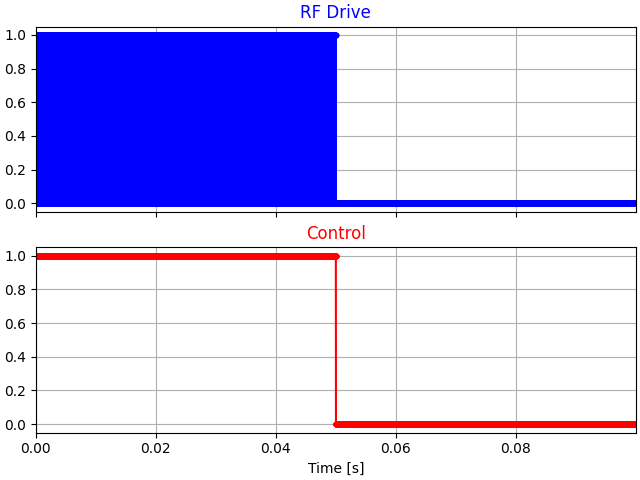

In [1]:
%matplotlib widget
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

samplingRate = 20000
signalFreqRF = 24.5e3; signalDutyRF = 50

signalDuration = 0.05

time = np.linspace(0, 2*signalDuration, samplingRate, endpoint=False)
signalControl = (signal.square(2*np.pi*1*time, 0.5*max(time))+1)/2
signalRF = signalControl*(signal.square(2*np.pi*signalFreqRF*time, signalDutyRF/100)+1)/2

## plotting
figHandler, axHandler = plt.subplots(2, 1, layout='constrained', sharex=True)

axHandler[0].set_title('RF Drive', color='b')
axHandler[0].plot(time, signalRF,'.-b', label='RF')
axHandler[0].set_xlim([0, max(time)])
axHandler[0].grid(True)

axHandler[1].set_title('Control', color='r')
axHandler[1].plot(time, signalControl,'.-r', label='Signal')
axHandler[1].set_xlim([0, max(time)])
axHandler[1].grid(True)

plt.xlabel('Time [s]')
plt.show()


In [ ]:
# import time
# from Instruments.Agilent import agilent3320A

# ## with driver
# funcGenAddr = 'USB0::0x0957::0x0407::MY44033388::0::INSTR'
# funcGen = agilent3320A(funcGenAddr)
# print(funcGen.identifyDevice())

# ## main
# funcGen.signalShape('PULSE') ## pulse waveform, because square sucks
# funcGen.signalFreq(24.5e3) # 24.5kHz
# funcGen.signalTTL(0, 1) ## TTL 0 to 1V
# funcGen.signalDC(50) ## duty cycle

# funcGen.burstState(1) ## enable burst mode
# funcGen.burstCycle(10) ## 10 cycle per burst
# funcGen.burstMode('TRIGGERED') ## apply on trigger
# funcGen.triggerSource('BUS') ## will be triggered with TRG*

# funcGen.enableOutput(1) ## enable output
# funcGen.trigger(1) ## trigger the burst
# time.sleep(3)
# funcGen.write(0) ## trigger back
# funcGen.enableOutput(0) ## disable output
# funcGen.beep() ## beep

# funcGen.closeDevice()

In [154]:
import time
import pyvisa

## with direct pyvisa
funcGenAddr = 'USB0::0x0957::0x0407::MY44033388::0::INSTR'
resMan = pyvisa.ResourceManager()
funcGen = resMan.open_resource(funcGenAddr)

## main
funcGen.write('FUNC PULSE') ## pulse waveform, because square sucks
funcGen.write('FREQ 24500') # 24.5kHz
funcGen.write('VOLT:LOW 0'); funcGen.write('VOLT:HIGH 1') ## TTL 0 to 1V
funcGen.write('FUNC:PULS:DCYC 10') ## duty cycle

funcGen.write('BURS:STAT 1') ## enable burst mode
funcGen.write('BURS:NCYC MAX') ## 10 cycles per burst
funcGen.write('BURS:MODE TRIGGERED') ## apply on trigger
funcGen.write('TRIG:SOUR BUS') ## will be triggered with TRG*

# funcGen.write('OUTP 1') ## enable output
# funcGen.write('OUTP:TRIG ON') ## enable trigger
funcGen.write('*TRG') ## trigger the burst
time.sleep(0.05)
# funcGen.write('OUTP:TRIG 0') ## trigger back
# funcGen.write('OUTP 0') ## disable output
funcGen.write('SYST:BEEP')

funcGen.close()

In [136]:
import time
from Instruments.Agilent import agilent3320A

## with driver
funcGenAddr = 'USB0::0x0957::0x0407::MY44033388::0::INSTR'
funcGen = agilent3320A(funcGenAddr)
print(funcGen.identifyDevice())

# ## with direct pyvisa
# resMan = pyvisa.ResourceManager()
# funcGen = resMan.open_resource(funcGenAddr)

## main
funcGen.signalShape('PULSE') ## pulse waveform, because square sucks
funcGen.signalFreq(24.5e3) # 24.5kHz
funcGen.write('VOLT:LOW 0'); funcGen.write('VOLT:HIGH 1') 
funcGen.write('FUNC:PULS:DCYC 50') ## duty cycle

funcGen.burstState(1) ## enable burst mode
funcGen.write('BURS:NCYC 1') ## 10 cycles per burst
funcGen.burstMode('TRIGGERED') ## apply on trigger
funcGen.triggerSource('BUS') ## will be triggered with TRG*

funcGen.enableOutput(1) ## enable output
funcGen.write('OUTP:TRIG 1') ## enable trigger
funcGen.write('*TRG') ## trigger the burst
time.sleep(1)
# funcGen.write('OUTP:TRIG 0') ## trigger back
# funcGen.enableOutput(0)
funcGen.beep() ## beep

# funcGen.closeDevice()

Agilent Technologies,33220A,MY44033388,2.02-2.02-22-2


0

In [87]:
funcGen.write('OUTP:TRIG 1') ## trigger the burst
time.sleep(0.05)
funcGen.write('OUTP:TRIG 0') ## trigger back
funcGen.beep() ## beep

0

In [8]:
# import time
# from Instruments.Agilent import agilent3320A

# funcGenAddr = 'USB0::0x0957::0x0407::MY44033388::0::INSTR'
# funcGen = agilent3320A(funcGenAddr)
# print(funcGen.identifyDevice())
# funcGen.enableOutput(0) ## disable output

# ## pwm
# ## carrier is the signal to the laser
# funcGen.signalShape('PULS') ## carrier shape
# funcGen.signalFreq(1e3) ## carrier freq
# funcGen.write('VOLT:LOW 0'); funcGen.write('VOLT:HIGH 1') ## TTL 0 to 1V
# funcGen.write('FUNC:PULS:DCYC 50') ## duty cycle

# ## modulation is the pulse
# funcGen.write('PWM:INT:FUNC SQUARE') ## modulating shape
# funcGen.write('PWM:INT:FREQ 11') ## modulating freq
# funcGen.write('PWM:DEV:DCYC 49.9') ## modulation depth (less than fifty)

# funcGen.write('PWM:SOUR INT') ## source: internal
# funcGen.write('PWM:STAT ON') ## turn on PWM state

# funcGen.enableOutput(1) ## enable output
# time.sleep(3)
# funcGen.write('PWM:STAT OFF') ## turn off PWM state
# funcGen.enableOutput(0) ## disable output
# funcGen.beep() ## beep

# funcGen.closeDevice()

In [ ]:
# import time
# from Instruments.Agilent import agilent3320A

# funcGenAddr = 'USB0::0x0957::0x0407::MY44033388::0::INSTR'
# funcGen = agilent3320A(funcGenAddr)
# print(funcGen.identifyDevice())
# funcGen.enableOutput(0) ## disable output

# ## am
# ## carrier is the pulse
# funcGen.signalShape('SQUARE') ## carrier shape
# funcGen.signalFreq(11) ## carrier freq
# funcGen.write('VOLT:LOW 0'); funcGen.write('VOLT:HIGH 1') ## TTL 0 to 1V
# funcGen.write('FUNC:SQUARE:DCYC 50') ## duty cycle, max is 80%

# ## modulation is the signal to the laser
# funcGen.write('AM:INT:FUNC SQUARE') ## modulating shape
# funcGen.write('AM:INT:FREQ 20000') ## modulating freq
# funcGen.write('AM:DEPTH 100') ## modulation depth
# funcGen.write('AM:STAT 1') ## turn on AM state

# funcGen.enableOutput(1) ## enable output
# time.sleep(3)
# funcGen.write('AM:STAT OFF') ## turn off AM state
# funcGen.enableOutput(0) ## disable output
# funcGen.beep() ## beep

# funcGen.closeDevice()

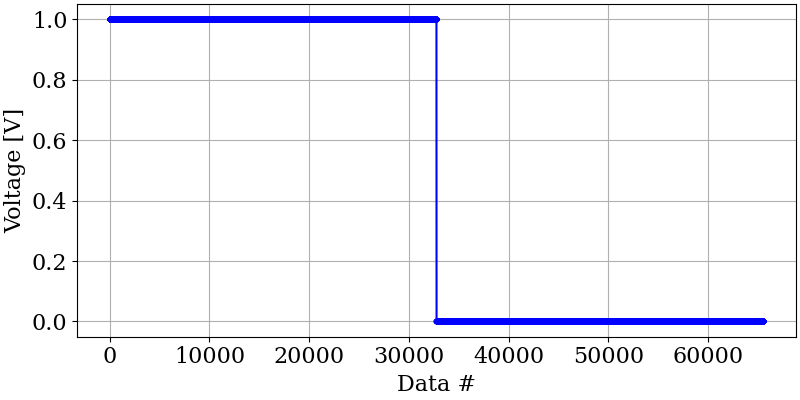

In [24]:
%matplotlib widget
import os
import csv
import time
import scipy
import psutil
import pyvisa
import random
import asyncio
import threading
import numpy as np
import pandas as pd
import nidaqmx as ni
from ctypes import *
from nidaqmx import constants
import ipywidgets as widgets
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.autolayout'] = True; plt.rc('font', size=16)
plt.rc('text', usetex=False); plt.rc('font', family='serif'); plt.rcParams['figure.figsize'] = (8, 4)

dataLength = 65536
signalFreqRF = 20; signalDutyRF = 50
timeDuration = 0.05

data = np.linspace(0, dataLength, dataLength, endpoint=False)
time = np.linspace(0, timeDuration, dataLength, endpoint=False)
signalRF = 0.5*(scipy.signal.square(2*np.pi*signalFreqRF*time, signalDutyRF/100)+1)

figHandler, axHandler = plt.subplots(1, 1, layout='constrained')
plt.plot(data, signalRF,'.-b', label='RF')
plt.xlabel('Data #'); plt.ylabel('Voltage [V]')
plt.grid(True)
plt.show()